In [58]:
import os
gpu_num = 0 # 使用 "" 来启用 CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

tf.random.set_seed(1) # Set global random seed for reproducibility
import matplotlib.pyplot as plt
import numpy as np
import sionna

# Import Sionna RT components
from sionna.channel import subcarrier_frequencies, cir_to_ofdm_channel
from mysionna.rt import load_scene, Transmitter, Receiver, PlanarArray
from mysionna.rt.scattering_pattern import *
from mysionna.rt.scene import load_sensing_scene, Target

In [59]:
tg = Target("meshes/car.ply","itu_metal",(0,0,0))
scene = load_sensing_scene("./scenes/Street/street.xml",tg)
# scene = load_scene("./scenes/Street/street.xml")
N=32

In [60]:
# scene.preview()

In [61]:
#################配置发端天线阵列#################
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="V")

#################配置收端天线阵列#################
scene.rx_array = PlanarArray(num_rows=N,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="V")

In [62]:
################创建发射机#########################
tx = Transmitter(name="tx",
                 position=[32.8,0,50.3])
################ 将发射机加入到场景中##############
scene.add(tx)
#################创建接收机########################
rx = Receiver(name="rx",
              position=[32.8,0,50.3])
################ 将接收机加入到场景中##############
scene.add(rx)


In [63]:
scene.frequency = 6e9 # in Hz; implicitly updates RadioMaterials
scene.synthetic_array = True # If set to False, ray tracing will be done per antenna element (slower for large arrays)

In [64]:
scene.target_names = ["car"]
scene.target_velocities = [(10,0,0.0)]

In [65]:
p1 = LambertianPattern()
p2 = DirectivePattern(20)
if scene.get("itu_plywood") is not None:
    scene.get("itu_plywood").scattering_coefficient = 0.3
    scene.get("itu_plywood").scattering_pattern = p1
if scene.get("itu_concrete") is not None:
    scene.get("itu_concrete").scattering_coefficient = 0.5
    scene.get("itu_concrete").scattering_pattern = p1
if scene.get("itu_glass") is not None:
    scene.get("itu_glass").scattering_coefficient = 0.25
    scene.get("itu_glass").scattering_pattern = p2
if scene.get("itu_medium_dry_ground") is not None:
    scene.get("itu_medium_dry_ground").scattering_coefficient = 0.8
    scene.get("itu_medium_dry_ground").scattering_pattern = p1
if scene.get("itu_metal") is not None:
    scene.get("itu_metal").scattering_coefficient = 0.1
    scene.get("itu_metal").scattering_pattern = p2

In [66]:
# crbs = scene.coverage_map_sensing(only_target=True,
#                                   map_center=[0,0,2.95],
#                                   map_size_x=10,
#                                   map_size_y=6,
#                                   cell_size=0.5,
#                                   look_at=[-3.37234,2.18367,1.20838],
#                                   batch_size=10,
#                                   singleBS=True,
#                                   num_samples=1000000,
#                                   max_depth=3,
#                                   diffraction=True,
#                                   edge_diffraction=True,
#                                   num_time_steps=1)

In [67]:
# crb = None
# for i in range(0,len(crbs)):
#     c = crbs[i][0]
#     c = tf.squeeze(c)
#     # c = tf.linalg.diag_part(c)
#     c = c.numpy()
#     if crb is None:
#         crb = c
#     else:
#         crb = np.concatenate((crb,c),axis=None)
# crb = np.array(crb)
# crb = np.reshape(crb,[-1,13])
# # np.save("./Data/indoor/table1/crb.npy",crb)
# crb = np.log10(crb)
# crb = np.rot90(crb)
# crb = np.flip(crb,axis=0)
# crb = np.flip(crb,axis=1)
# plt.imshow(crb)
# plt.colorbar()


In [68]:
paths = scene.compute_paths(max_depth=1,reflection=False,diffraction=True,scattering=True,edge_diffraction=True,scat_keep_prob=0.01)
paths.normalize_delays = False

In [69]:
# scene.preview(paths=paths)

Text(0, 0.5, '$|a|$')

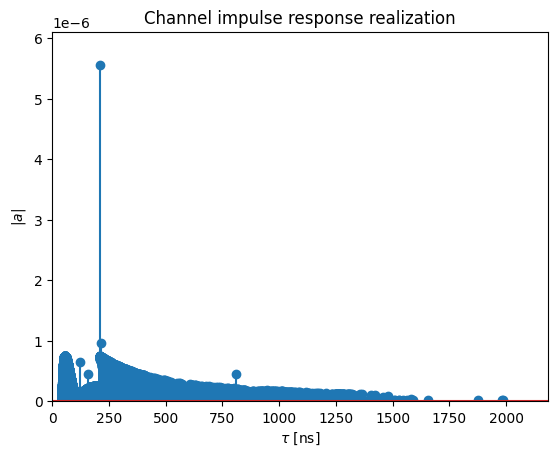

In [70]:
a, tau = paths.cir()
t = tau[0,0,0,:]/1e-9 # Scale to ns
a_abs = np.abs(a)[0,0,0,0,0,:,0]
t = t[a_abs!=0]
a_abs = a_abs[a_abs!=0]
a_max = np.max(a_abs)
# Add dummy entry at start/end for nicer figure
t = np.concatenate([(0.,), t, (np.max(t)*1.1,)])
a_abs = np.concatenate([(np.nan,), a_abs, (np.nan,)])

# And plot the CIR
plt.figure()
plt.title("Channel impulse response realization")

plt.stem(t, a_abs)
plt.xlim([0, np.max(t)])
plt.ylim([0, a_max*1.1])
plt.xlabel(r"$\tau$ [ns]")
plt.ylabel(r"$|a|$")

In [71]:
v,obj=scene.compute_target_velocities(paths, return_obj_names=True)

In [72]:
subcarrier_spacing = 15e3
num_time_steps = 14
paths.apply_doppler(sampling_frequency=subcarrier_spacing, num_time_steps=num_time_steps,target_velocities=v)

In [73]:
a,tau = paths.cir()
subcarrier_num = 64
subcarrier_spacing = 15e3
frequencies = subcarrier_frequencies(subcarrier_num, subcarrier_spacing)
h_freq = cir_to_ofdm_channel(frequencies, a, tau, normalize=True)
ebno_db = 20

In [57]:
h_env = h_freq

In [74]:
h_all = h_freq

In [75]:
h_target = h_all-h_env

In [ ]:
H_sortidx = np.argsort(np.abs(a[0,0,0,0,0,:,0]))
tau=paths.tau[0,0,0,:]
tau_true = tf.squeeze(tau)[H_sortidx[-1]] * 1e9

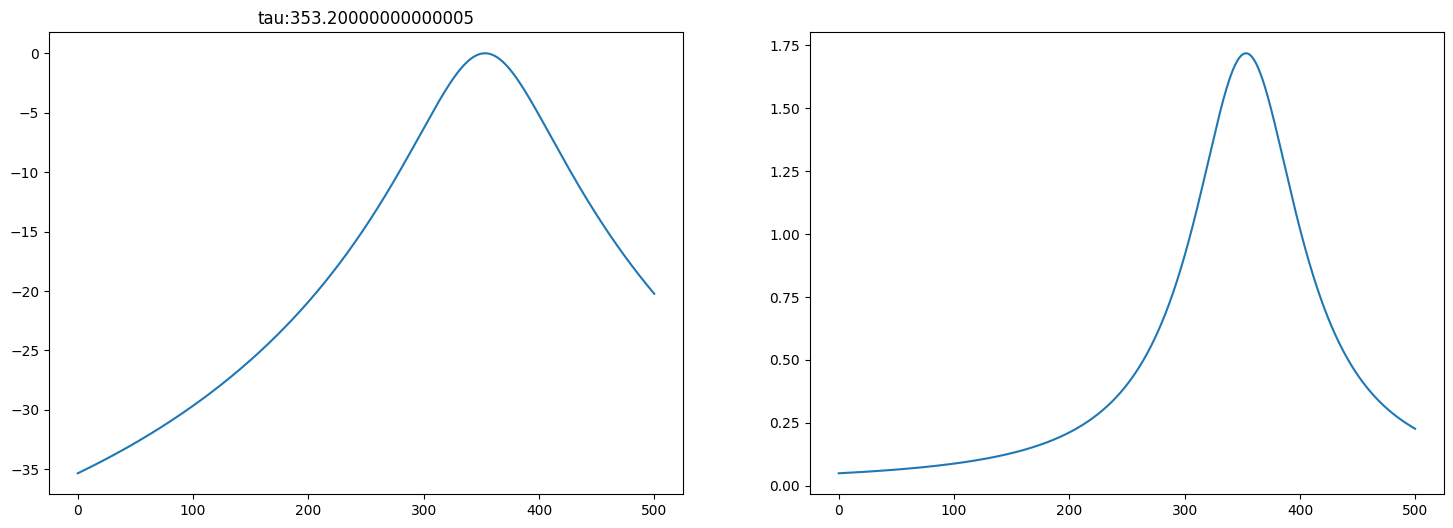

In [76]:
# 时延估计
start = 0
end = 500
step = 0.1
y_i = h_target[0,0,0,0,0,0,:]
y_i = tf.squeeze(y_i)
y_i = tf.expand_dims(y_i, axis=0)
y_i_H = tf.transpose(tf.math.conj(y_i))
y_conv = tf.matmul(y_i_H, y_i)
eig_vals, eig_vecs = tf.linalg.eigh(y_conv)
tau_range = np.arange(start,end, step)
G_n = tf.cast(eig_vecs[:,:-2], dtype=tf.complex64)
G_n_H = tf.math.conj(tf.transpose(G_n))
frequencies_c1 = tf.expand_dims(frequencies, axis=0)
frequencies_c1 = tf.repeat(frequencies_c1, len(tau_range), axis=0)
frequencies_c1 = tf.cast(frequencies_c1, dtype=tf.complex64)
tau_range1 = tf.expand_dims(tau_range, axis=-1)
tau_range1 = tf.repeat(tau_range1, subcarrier_num, axis=-1)
tau_range1 = tf.cast(tau_range1, dtype=tf.complex64)
a_m = tf.math.exp(-1j * 2 * np.pi * frequencies_c1 * (tau_range1/1e9))
a_m_H = tf.math.conj(tf.transpose(a_m))
a_m_H = tf.expand_dims(a_m_H, axis=1)
a_m_H = tf.transpose(a_m_H, perm=[2,0,1])
a_m = tf.expand_dims(a_m, axis=1)
G_n = tf.expand_dims(G_n, axis=0)
G_n_H = tf.expand_dims(G_n_H, axis=0)
P = 1 / (a_m @ G_n @ G_n_H @ a_m_H)
P = tf.squeeze(P)
# 计算谱函数
P_tau_real, P_tau_imag = tf.math.real(P), tf.math.imag(P)
P_abs = tf.math.sqrt(P_tau_real**2 + P_tau_imag**2)
P_norm = 10 * tf.math.log(P_abs / tf.reduce_max(P_abs), 10)
P_norm = tf.squeeze(P_norm)
max_idx = tf.argmax(P_norm)
# 绘制
# 调整画布大小
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(tau_range, tf.squeeze(P_norm))
plt.title(f"tau:{(start + int(max_idx) * step)}")
plt.subplot(1, 2, 2)
plt.plot(tau_range, tf.squeeze(P_abs))

In [77]:
(start + int(max_idx) * step)*0.15

52.980000000000004

In [39]:
tau_true*0.15

<tf.Tensor: shape=(), dtype=float32, numpy=58.156776>

/tmp/ipykernel_8699/451752205.py:45: UserWarning: Trying to create polar plot on an Axes that does not have a polar projection.
  plt.polar(range,tf.squeeze(P_norm))
/tmp/ipykernel_8699/451752205.py:48: UserWarning: Trying to create polar plot on an Axes that does not have a polar projection.
  plt.polar(range,tf.squeeze(P_abs))


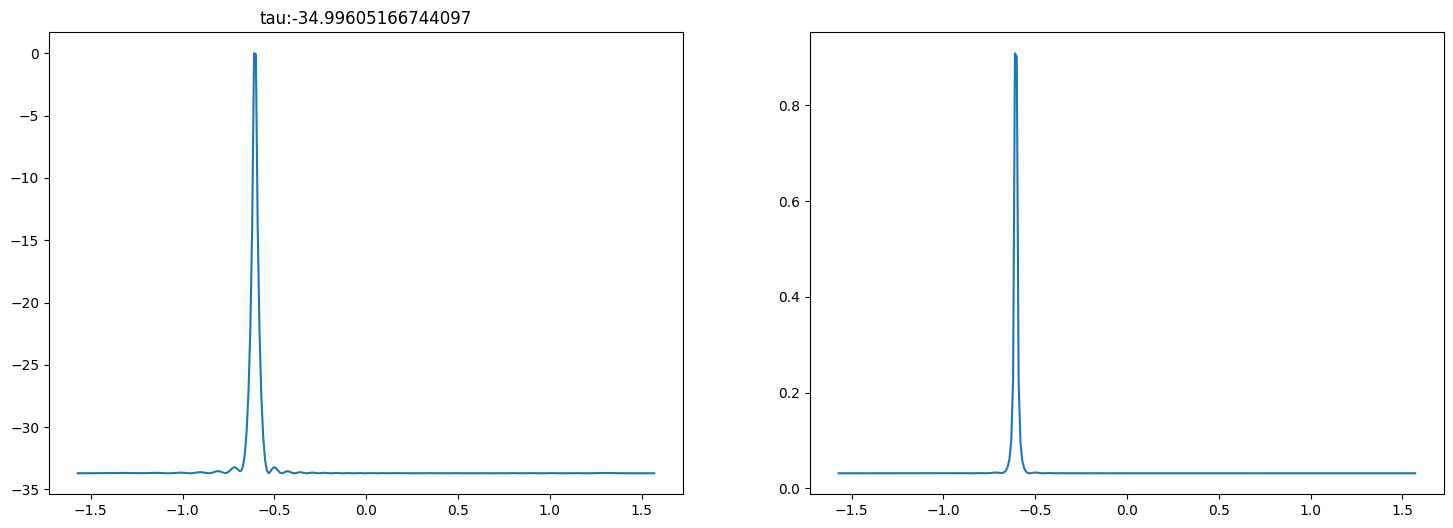

In [32]:
# 角度估计
start = -np.pi/2
end = np.pi/2
step = 0.01
# 信道
y_i = h_freq[0,0,:,0,0,0,0]
y_i = tf.squeeze(y_i)
y_i = tf.expand_dims(y_i, axis=0)
y_i_H = tf.transpose(tf.math.conj(y_i))
y_conv = tf.matmul(y_i_H, y_i)
# 特征值分解
eig_vals, eig_vecs = tf.linalg.eigh(y_conv)
range = np.arange(start,end, step)
G_n = tf.cast(eig_vecs[:,:-1], dtype=tf.complex64)
G_n_H = tf.math.conj(tf.transpose(G_n))
# 矢量
lambda_ = 3e8 / scene.frequency
z = np.arange(0,N,1)
c1 = tf.expand_dims(z, axis=0)
c1 = tf.repeat(c1, len(range), axis=0)
c1 = tf.cast(c1, dtype=tf.complex64)
range1 = tf.expand_dims(range, axis=-1)
range1 = tf.repeat(range1, N, axis=-1)
range1 = tf.cast(range1, dtype=tf.complex64)
k = tf.cast(np.pi, dtype=tf.complex64)
a_m = tf.math.exp(1j * k * c1 * tf.math.sin(range1))
a_m_H = tf.math.conj(tf.transpose(a_m))
a_m_H = tf.expand_dims(a_m_H, axis=1)
a_m_H = tf.transpose(a_m_H, perm=[2,0,1])
a_m = tf.expand_dims(a_m, axis=1)
G_n = tf.expand_dims(G_n, axis=0)
G_n_H = tf.expand_dims(G_n_H, axis=0)
P = 1 / (a_m @ G_n @ G_n_H @ a_m_H)
P = tf.squeeze(P)
# 计算谱函数
P_tau_real, P_tau_imag = tf.math.real(P), tf.math.imag(P)
P_abs = tf.math.sqrt(P_tau_real**2 + P_tau_imag**2)
P_norm = 10 * tf.math.log(P_abs / tf.reduce_max(P_abs), 10)
P_norm = tf.squeeze(P_norm)
max_idx = tf.argmax(P_norm)
# 绘制
# 调整画布大小
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.polar(range,tf.squeeze(P_norm))
plt.title(f"tau:{(start + int(max_idx) * step)*180/np.pi}")
plt.subplot(1, 2, 2)
plt.polar(range,tf.squeeze(P_abs))

In [ ]:
eig_vals

In [ ]:
crb = paths.crb_delay()

In [12]:
paths.export_crb(crb,"test.xyzrgb",BS_pos = [0,0,2.95])

True

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
scene_name = "indoor"
target = "human1"
#read config and turn it to global variables
config = json.load(open("crb_validation_config.json"))
subcarrier_spacing = config.get("subcarrier_spacing")
subcarrier_num = config.get("subcarrier_num")
num_time_steps = config.get("num_time_steps")
ebno_db = config.get("ebno_db")
num_samples = config.get("num_samples")
batch_size = config.get("batch_size")
max_depth = config.get("max_depth")
step = config.get("step")
los = config.get("los")
reflection = config.get("reflection")
scattering = config.get("scattering")
diffraction = config.get("diffraction")
edge_diffraction = config.get("edge_diffraction")
ray_type = "TTTTT"
x = 10
y = 6
cell_size = 0.5
col = int(y/cell_size)+1
title = f"{num_samples}-{ray_type}-{max_depth}-{step}-{batch_size}-{x}-{y}-{cell_size}"
with open(f"./Data/{scene_name}/{target}/{title}/tau_true.txt","r") as f:
    tau_true = f.readlines()
    tau_true = np.array([float(i) for i in tau_true])
with open(f"./Data/{scene_name}/{target}/{title}/tau_est.txt","r") as f:
    tau_est = f.readlines()
    tau_est = np.array([float(i) for i in tau_est])
crb = np.load(f"./Data/{scene_name}/{target}/{title}/crb.npy")
crb = crb*3e8
crb = np.log10(crb)
crb = np.reshape(crb,(-1,col))

pad = 0

mse = np.abs(tau_true-tau_est)
mse = np.reshape(mse,(-1,col))
tau_true = np.reshape(tau_true,(-1,col))
tau_est = np.reshape(tau_est,(-1,col))
mask = mse >= 1
mse[mask] = pad
mask = tau_est==0
mse[mask] = pad
mask = tau_true==999999 
mse[mask] = pad
mask = tau_true==0
mse[mask] = pad
mask = tau_true==-1
mse[mask] = pad
mse = mse*3e8
mse = np.log10(mse)
# 逆时针旋转九十度
mse = np.rot90(mse)
crb = np.rot90(crb)
# x轴对称
mse = np.flip(mse,1)
crb = np.flip(crb,1)
mse = np.flip(mse,0)
crb = np.flip(crb,0)
# set figure size
plt.figure(figsize=(10, 5))
plt.subplots_adjust(wspace=0.5)
plt.subplot(121)
plt.title("Indoor Sensing MSE")
plt.xlabel("x axis(0.5m)")
plt.ylabel("y axis(0.5m)")
plt.imshow(mse)
# set colorbar size
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(122)
plt.title("Indoor Sensing CRB")
plt.xlabel("x axis(0.5m)")
plt.ylabel("y axis(0.5m)")
plt.imshow(crb)
plt.colorbar(fraction=0.046, pad=0.04)
plt.savefig(f"./Data/{scene_name}/{target}/out.png")

In [ ]:
import mitsuba as mi
scene_params = mi.traverse(scene._scene)
scene_params

In [ ]:
human = mi.load_dict({'type': 'ply',
                    'filename': './scenes/Indoor/meshes/human1.ply'})
human

In [ ]:
scene._scene.shapes()